<a href="https://colab.research.google.com/github/SteffanBurnette/TensorFlow-/blob/Xray_lung_classification/Pneumonia_classification_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Chest X-Ray Disease Classification
The dataset that I will be using to train the neural network is a **prelabeled PNEUMONIA** dataset. The goal of this project is to create a **convolutional neural network** that will be able to take X-rays of a patients chest as input and identify if that individual has pneumonia or not.

In [1]:
!pip install -q opendatasets

In [2]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images") # insert ypu kaggle  username and key
#pddf = pd.read_csv('/content/dish-network-hackathon/Test_Dataset.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: frentr
Your Kaggle Key: ··········


100%|██████████| 1.17G/1.17G [00:13<00:00, 91.8MB/s]


###Setting up the project environment
Here, I am imported the required dependancies that will allow me to complete this task. I plan on importing a pretrain model that is used for image classification and performing transfer learning via tensorflow hub.

In [25]:
!pip install opencv-python

In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt #Used to visualize data and findings
from tensorflow.keras.models import Sequential #Will use a layer to layer architecture
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D  #Will maybe utilize the Conv2D and MaxPool layers depending on the initial findings
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy #Will use binary as the loss function
from tensorflow.keras.optimizers import Adam, SGD #Used to reduce the loss while simultaniously increasing the models accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Used to load in in preprocess the image data
import tensorflow_hub as hub #Used to load in the model from tensorflow hub

###Visualize the data
Great, now lets first set up the directories and visualize the data that we will be working with.

In [4]:
train_dir = "/content/labeled-chest-xray-images/chest_xray/train"
train_dir_normal = "/content/labeled-chest-xray-images/chest_xray/train/NORMAL"
train_dir_pneumonia = "/content/labeled-chest-xray-images/chest_xray/train/PNEUMONIA"
test_dir = "/content/labeled-chest-xray-images/chest_xray/test"
test_dir_normal = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL"
test_dir_pneumonia = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA"


print(f"The test directory has {len(test_dir_normal)} normal xrays and {len(test_dir_pneumonia)} pneumonia xrays")
print(f"The train directory has {len(train_dir_normal)} normal xrays and {len(train_dir_pneumonia)} pneumonia xrays")
print("Roughly the same amount of examples in each directory")
len(train_dir), len(test_dir)

The test directory has 57 normal xrays and 60 pneumonia xrays
The train directory has 58 normal xrays and 61 pneumonia xrays
Roughly the same amount of examples in each directory


(51, 50)

###Findings
The test and training directory has roughly a 80-20 split. Since I will be leveraging the **efficientnet model** this is looking to be promising since the data is properly labeled and split in an ideal manner. If however I find that the model is **underfitting/Overfitting** during training I will move/augment some of the data to the train dataset.

In [5]:
#Setting up the inital params
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

#When loading in the images, it will normalize the data to fit the model better
train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)

print("Training images data: ")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size = IMAGE_SHAPE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = "binary")

print("Test data images data: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode = "binary")


Training images data: 
Found 5232 images belonging to 2 classes.
Test data images data: 
Found 624 images belonging to 2 classes.


###Loading the Efficientnet model from Tensorflow hub
Now I will load the model from tensorflow hub as a **kerasLayer**

In [6]:
#The url that i will be loading the model from
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

 #Downloads the pretrained model and save it as a keras layer
feature_extraction_layer = hub.KerasLayer(efficientnet_url,
                                             trainable = False,#Freezes the patterns that the pretrained model has learned
                                             name = "Feature_Extraction_Layer",
                                             input_shape = IMAGE_SHAPE+(3,)) #Turns shape into (224, 224, 3)
    #We will be able to put the entire model as a layer into the model that we create

    #Create our own model
model = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [7]:
train_data[0]

(array([[[[0.14901961, 0.14901961, 0.14901961],
          [0.20392159, 0.20392159, 0.20392159],
          [0.38823533, 0.38823533, 0.38823533],
          ...,
          [0.2784314 , 0.2784314 , 0.2784314 ],
          [0.22352943, 0.22352943, 0.22352943],
          [0.14901961, 0.14901961, 0.14901961]],
 
         [[0.15294118, 0.15294118, 0.15294118],
          [0.15294118, 0.15294118, 0.15294118],
          [0.2509804 , 0.2509804 , 0.2509804 ],
          ...,
          [0.24705884, 0.24705884, 0.24705884],
          [0.18039216, 0.18039216, 0.18039216],
          [0.13333334, 0.13333334, 0.13333334]],
 
         [[0.14901961, 0.14901961, 0.14901961],
          [0.17254902, 0.17254902, 0.17254902],
          [0.14117648, 0.14117648, 0.14117648],
          ...,
          [0.22352943, 0.22352943, 0.22352943],
          [0.20784315, 0.20784315, 0.20784315],
          [0.13725491, 0.13725491, 0.13725491]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

###Compiling and Fitting the model
Will now compile the model and fit it to the training data while evaluating it's performance with the test data

In [8]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history = model.fit(train_data, epochs = 15, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/15
164/164 [==============================] - 64s 329ms/step - loss: 0.2735 - accuracy: 0.8947 - val_loss: 0.3470 - val_accuracy: 0.8301
Epoch 2/15
164/164 [==============================] - 52s 318ms/step - loss: 0.1497 - accuracy: 0.9492 - val_loss: 0.2999 - val_accuracy: 0.8622
Epoch 3/15
164/164 [==============================] - 53s 325ms/step - loss: 0.1221 - accuracy: 0.9612 - val_loss: 0.2765 - val_accuracy: 0.8750
Epoch 4/15
164/164 [==============================] - 53s 320ms/step - loss: 0.1046 - accuracy: 0.9667 - val_loss: 0.2792 - val_accuracy: 0.8798
Epoch 5/15
164/164 [==============================] - 53s 324ms/step - loss: 0.0938 - accuracy: 0.9694 - val_loss: 0.2390 - val_accuracy: 0.8942
Epoch 6/15
164/164 [==============================] - 53s 324ms/step - loss: 0.0864 - accuracy: 0.9729 - val_loss: 0.2481 - val_accuracy: 0.8878
Epoch 7/15
164/164 [==============================] - 53s 321ms/step - loss: 0.0798 - accuracy: 0.9746 - val_loss: 0.2408 - val_ac

###Model after training
Would you look at that!!, the model performed with 98% accuracy on the training data and 88% accuracy on the test data(unseen data). This is very good and while there are things that can be done to increase the performance(finding the **ideal learning rate** or performing **fine tuning**) this is still a really good outcome. Now lets plot the **loss curves** and see a visual representation of our models performance.

In [9]:
#Lets create a function to plot our loss curves
#Note that this function will fail if we are using an evaluation metric that is not accuracy
#Plot the validation and training curves seperately
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #How many epochs did we run for

  #Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs,val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

    #Plot Accuracy
  plt.figure() #Creates a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs,val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

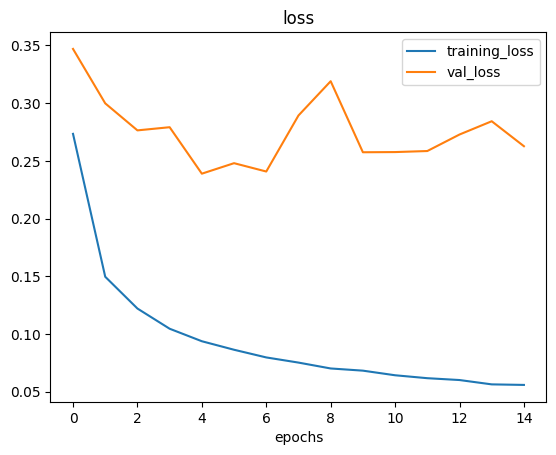

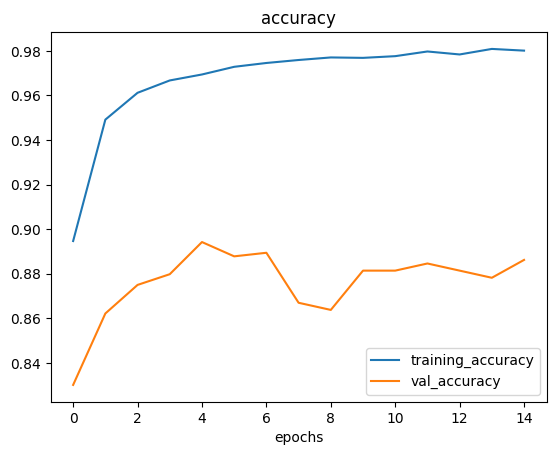

In [10]:
plot_loss_curves(history)

There seems to be some potential signs of overfitting, but lets perform some prediction and see if our model performs well.

In [11]:
#Get sample data batches
images, labels = train_data.next()


Showing random image number: 24


<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, *, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

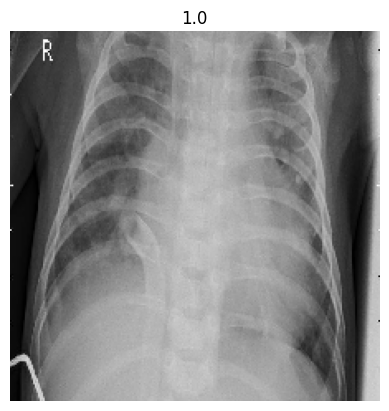

In [16]:
#Show the original image and the augmented image
random_number =random.randint(0, 31) #Our batch sizes are 32 so the random integer will be choosen from 0-31
print(f"Showing random image number: {random_number}")
plt.imshow(images[random_number])
plt.title(labels[random_number])
plt.axis(False);
plt.figure


In [19]:
model.predict(test_data)

20/20 [==============================] - 7s 294ms/step


array([[1.81734692e-02],
       [3.79463797e-03],
       [6.03904247e-01],
       [9.92503405e-01],
       [9.99991059e-01],
       [9.99986529e-01],
       [9.97745574e-01],
       [1.55041507e-02],
       [9.99931335e-01],
       [9.99888182e-01],
       [9.99985218e-01],
       [9.89325404e-01],
       [9.99901056e-01],
       [9.99985933e-01],
       [9.99963284e-01],
       [7.06679821e-02],
       [9.98795033e-01],
       [3.54583353e-01],
       [5.06822824e-01],
       [9.99808371e-01],
       [8.57254207e-01],
       [9.99526024e-01],
       [9.99816120e-01],
       [9.75449800e-01],
       [6.62235692e-02],
       [9.99974728e-01],
       [9.99966383e-01],
       [9.99955177e-01],
       [2.48835189e-03],
       [9.99313593e-01],
       [6.84911236e-02],
       [9.99959707e-01],
       [9.99657273e-01],
       [9.99906301e-01],
       [9.99602139e-01],
       [3.55960280e-02],
       [9.99967575e-01],
       [9.99959707e-01],
       [9.96919274e-01],
       [9.99960661e-01],


In [21]:
class_names = ["Normal", "Pneumonia"]

In [31]:
#Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_img(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, color_channels)
  """
  #Read in the image
  img = tf.io.read_file(filename)

  #Decode the read file into a tensor
  img = tf.image.decode_image(img)

  rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = rgb_image
  #Resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])
  #Rescale the image (get all values between 0 and 1)
  img=img/255.
  return img

In [47]:
#Experimental
def load_and_prep_img(filename, img_shape= 224):
    # Load in the image
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)

    # Check if the image is grayscale (if so, convert to RGB)
    if img.shape[-1] == 1:
        # Convert the image to a NumPy array
        img_array = img.numpy()
        # Convert grayscale to RGB
        rgb_image = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        img = tf.convert_to_tensor(rgb_image)

    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    # Rescale the image (if required)
    img = img/255. #(Only if your model expects pixel values in the range [0, 1])
    return img

In [39]:
def pred_and_plot(model, filename, class_names=class_names):
  """ Imports a image located at filename, makes a prediction with model and
  plots the image with the predicted class as the title
  """
  #Import the target image and preprocess it
  img = load_and_prep_img(filename)

  #Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  #Add in logic for predictions since a softmax function returns a nested list of multiple predictions
  #Unlike a sigmoid function which only returns the predicted value
  if len(pred)> 1: #Handles multiclass images logic
    pred_class = class_names[tf.argmax(pred[0])] #Gets the class name of the highest prediction value
  else:  #Handles binary class images logic
    #Get the predicted class
    pred_class = class_names[int(tf.round(pred[0]))]

  #Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 26ms/step


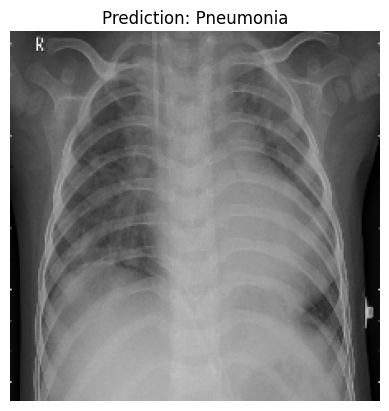

In [48]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg", class_names = class_names)

1/1 [==============================] - 0s 36ms/step


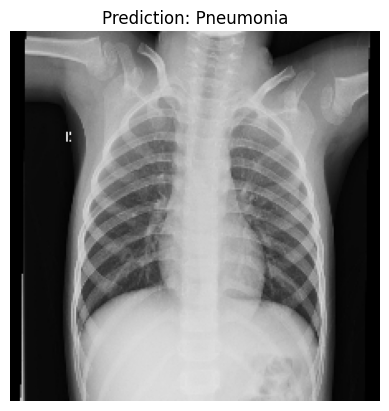

In [52]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 24ms/step


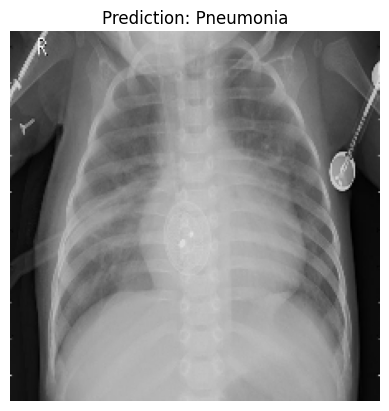

In [54]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg", class_names = class_names)

1/1 [==============================] - 0s 25ms/step


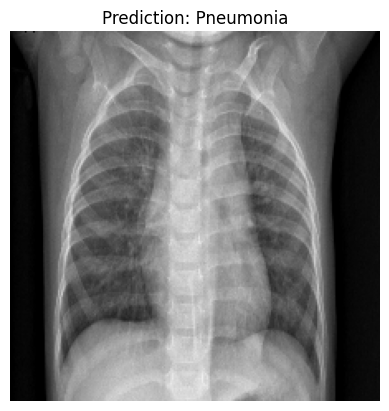

In [53]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 66ms/step


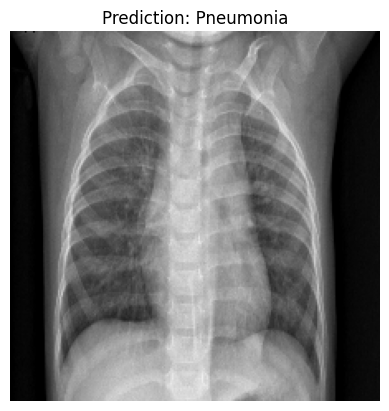

In [55]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 41ms/step


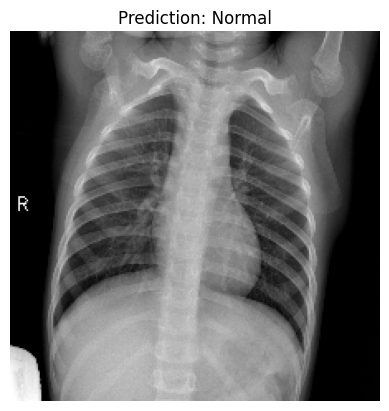

In [56]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-3395085-0001.jpeg", class_names = class_names)

1/1 [==============================] - 0s 26ms/step


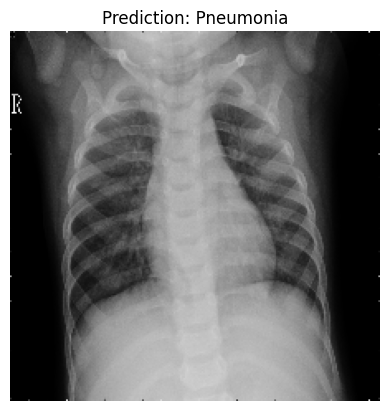

In [57]:
pred_and_plot(model = model, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-4315572-0001.jpeg", class_names = class_names)

###Takeaways
* The model has a hard time distinguishing a normal X-Ray from a pneumonia x-ray, which is to be expected since the efficientnet was trained on rgb images. Its still able to properly distingust **pneumonia x-rays**.

*First I will train the model fro less epochs and see if theres an improvement in the loss curves(from analizing it 5 epochs should be enough)

I will create a model from scratch to see if it will perform better, but this current model is not bad and will be saved.

###Creating a Second Model


In [58]:
   #Create our own model
model_2 = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [59]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model_2.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history_2 = model_2.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
164/164 [==============================] - 57s 328ms/step - loss: 0.3179 - accuracy: 0.8727 - val_loss: 0.3869 - val_accuracy: 0.7901
Epoch 2/5
164/164 [==============================] - 54s 328ms/step - loss: 0.1619 - accuracy: 0.9488 - val_loss: 0.3068 - val_accuracy: 0.8590
Epoch 3/5
164/164 [==============================] - 53s 322ms/step - loss: 0.1279 - accuracy: 0.9583 - val_loss: 0.2314 - val_accuracy: 0.9038
Epoch 4/5
164/164 [==============================] - 53s 323ms/step - loss: 0.1107 - accuracy: 0.9648 - val_loss: 0.2248 - val_accuracy: 0.9087
Epoch 5/5
164/164 [==============================] - 57s 350ms/step - loss: 0.0994 - accuracy: 0.9664 - val_loss: 0.2723 - val_accuracy: 0.8782


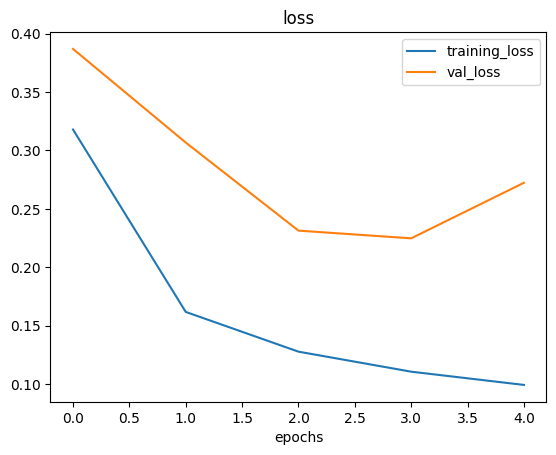

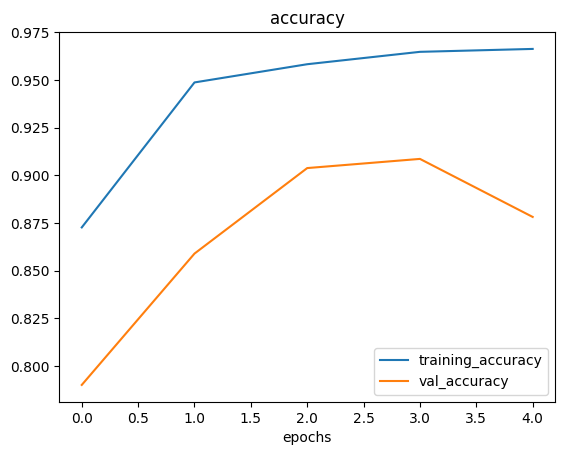

In [60]:
plot_loss_curves(history_2)

In [61]:
model_3 = Sequential([
        feature_extraction_layer, #Efficienet model will handle the inputs
        Dense(1, activation="sigmoid", name = "output_layer") #Only two categories: normal, pneumonia
    ])

In [62]:
#Setting up the loss function, optimizer and metric that the models performance will be evaluated on
model_3.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

#Will train and evaluate the model, while keep track of its training/evaluation history so that I can view the loss curves
history_3 = model_3.fit(train_data, epochs = 4, steps_per_epoch = len(train_data),
          validation_data = test_data, validation_steps = len(test_data))

Epoch 1/4
164/164 [==============================] - 58s 338ms/step - loss: 0.2828 - accuracy: 0.8842 - val_loss: 0.3674 - val_accuracy: 0.8077
Epoch 2/4
164/164 [==============================] - 54s 328ms/step - loss: 0.1528 - accuracy: 0.9484 - val_loss: 0.3137 - val_accuracy: 0.8542
Epoch 3/4
164/164 [==============================] - 54s 326ms/step - loss: 0.1226 - accuracy: 0.9606 - val_loss: 0.2985 - val_accuracy: 0.8622
Epoch 4/4
164/164 [==============================] - 54s 328ms/step - loss: 0.1060 - accuracy: 0.9671 - val_loss: 0.2871 - val_accuracy: 0.8766


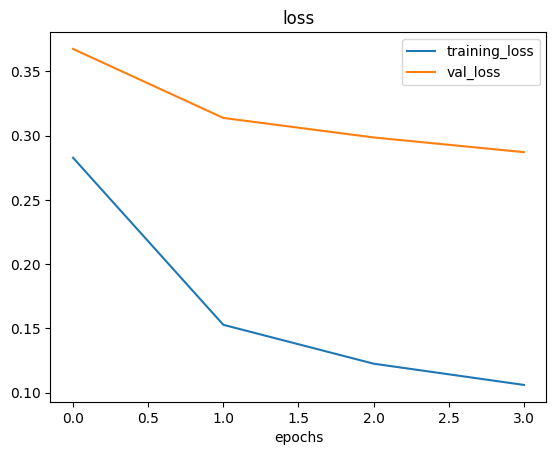

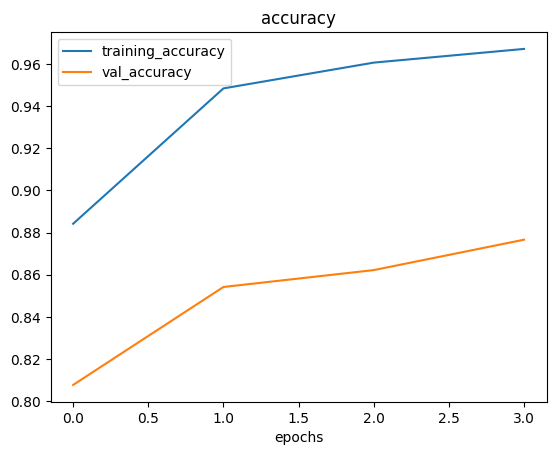

In [64]:
plot_loss_curves(history_3)

By training the model for less epochs, ive successfully reduced the **overfitting** that was occuring at the end of the first model's training. Now i will use it to predict the image values given and rate its results.

1/1 [==============================] - 0s 27ms/step


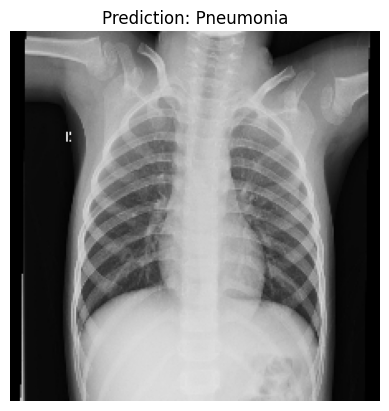

In [66]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg", class_names = class_names)



1/1 [==============================] - 0s 37ms/step


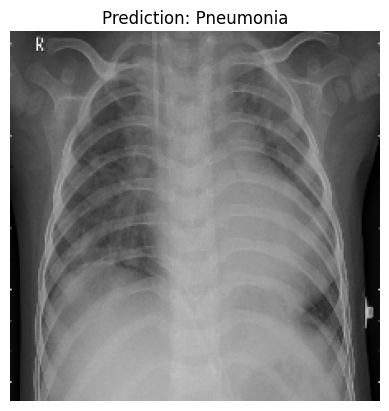

In [67]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg", class_names = class_names)


1/1 [==============================] - 0s 54ms/step


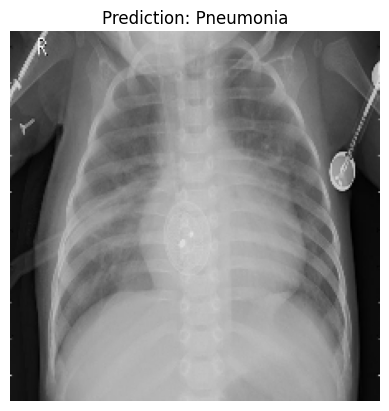

In [68]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1768914-0003.jpeg", class_names = class_names)


1/1 [==============================] - 0s 27ms/step


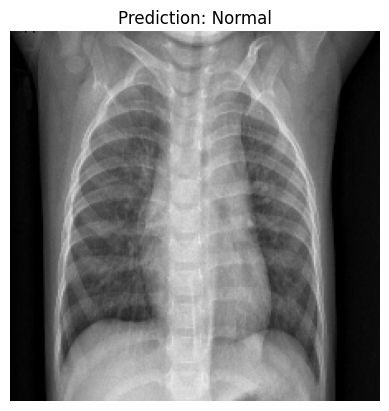

In [69]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


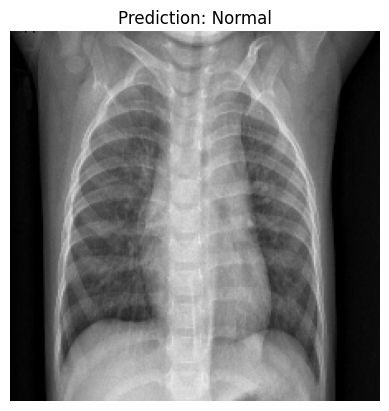

In [70]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


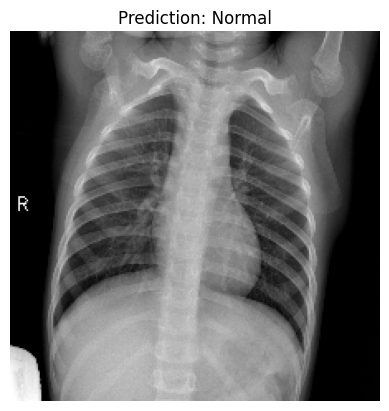

In [71]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-3395085-0001.jpeg", class_names = class_names)


1/1 [==============================] - 0s 26ms/step


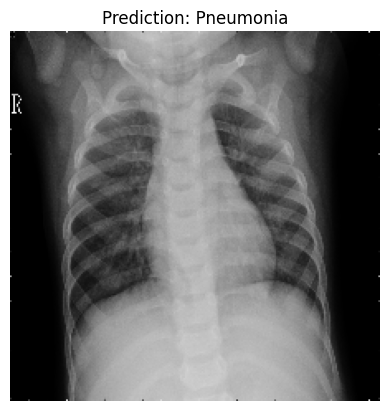

In [72]:
pred_and_plot(model = model_3, filename = "/content/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-4315572-0001.jpeg", class_names = class_names)

###Overall performance
While not correct on all predictions, `model_3` is out performing the first model c0onstructed and is indentifying the normal x-ray scans and pneumonia x ray scans more consistently. This is great news as it shows progress in the development of the neural network.

###Saving the neural network to be loaded in at a different time

In [73]:
model_3.save("Normal_and_Pneumonia_xray_classification")

In [78]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning Stuff/Normal_and_Pneumonia_xray_classification')